In [14]:
import os
import pandas as pd
from sklearn.feature_selection import SelectPercentile, f_classif, mutual_info_classif, RFECV
from sklearn.ensemble import RandomForestClassifier

# —— 一、配置路径 —— 
# 假设：数据集解压后目录是 ./UCI_HAR_Dataset/
# 里面直接包含 features.txt、train/、test/ 等
base_dir = './data/UCI_HAR_Dataset/'

# 如果你的目录中还有一个子文件夹 “UCI HAR Dataset”，则改为：
# base_dir = './UCI_HAR_Dataset/UCI HAR Dataset/'

# —— 二、加载特征名称 —— 
# 1. 原始特征名
feat_path = os.path.join(base_dir, 'features.txt')
feat = pd.read_csv(feat_path, sep='\s+', header=None, names=['idx','feat'])
feature_names = feat['feat'].tolist()

# 2. 读数据时先不指定 names
X_train = pd.read_csv(
    os.path.join(base_dir, 'train', 'X_train.txt'),
    sep='\s+', header=None
)
# 3. 再赋列名
X_train.columns = feature_names

y_train = pd.read_csv(
    os.path.join(base_dir, 'train', 'y_train.txt'),
    sep='\s+', header=None, names=['activity']
)['activity']

# # —— 三、加载训练数据 —— 
# X_train = pd.read_csv(
#     os.path.join(base_dir, 'train', 'X_train.txt'),
#     sep='\s+', header=None, names=feature_names
# )
# y_train = pd.read_csv(
#     os.path.join(base_dir, 'train', 'y_train.txt'),
#     sep='\s+', header=None, names=['activity']
# )['activity']

# —— 四、单变量特征选择（Top 10%） —— 
# ANOVA F‑test
anova = SelectPercentile(score_func=f_classif, percentile=10)
anova.fit(X_train, y_train)

# Mutual Information
mi = SelectPercentile(score_func=mutual_info_classif, percentile=10)
mi.fit(X_train, y_train)

# 汇总得分与筛选结果
df_uni = pd.DataFrame({
    'feature': feature_names,
    'anova_score': anova.scores_,
    'mi_score': mi.scores_,
    'selected_by_anova': anova.get_support(),
    'selected_by_mi': mi.get_support()
})
# 任何一种方法选中的都保留，并按得分排序
selected_uni = df_uni[
    df_uni['selected_by_anova'] | df_uni['selected_by_mi']
].sort_values(['anova_score','mi_score'], ascending=False)

print("— 前 10% 单变量选出特征（约 6 个）：")
print(selected_uni[['feature','anova_score','mi_score']].to_string(index=False))


# —— 五、递归特征消除（RFECV） —— 
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(
    estimator=clf,
    step=0.1,           # 每轮去掉 10% 最弱特征
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
rfecv.fit(X_train, y_train)

# 原 feature_names 是一个 Python 列表，先转成 numpy array
feat_array = np.array(feature_names)

# 用布尔掩码选出被 RFECV 支持的特征
rfe_feats = feat_array[rfecv.support_]

print(f"— RFECV 自动选择最佳特征数：{rfecv.n_features_}")
print("— 被选中的特征列表：")
for f in rfe_feats:
    print(f)



— 前 10% 单变量选出特征（约 6 个）：
                        feature  anova_score  mi_score
       fBodyAccJerk-entropy()-X 36918.103883  0.774437
           tGravityAcc-mean()-X 29362.642369  0.656894
            tGravityAcc-min()-X 28175.402833  0.822990
       fBodyAccJerk-entropy()-Y 28115.915817  0.733558
            tGravityAcc-max()-X 26686.804095  0.744468
         tGravityAcc-energy()-X 25981.558817  0.660014
  fBodyBodyAccJerkMag-entropy() 23619.245704  0.760501
      tBodyAccJerkMag-entropy() 23437.114915  0.796506
           fBodyAcc-entropy()-X 23221.614156  0.820657
       tBodyAccJerk-entropy()-X 22267.085935  0.739422
               tBodyAcc-max()-X 20276.388628  1.006908
       fBodyAccJerk-entropy()-Z 18959.058628  0.734263
       tBodyAccJerk-entropy()-Z 18686.064500  0.704871
       tBodyAccJerk-entropy()-Y 18294.206453  0.696753
               fBodyAcc-mad()-X 18276.433019  0.863247
               tBodyAcc-std()-X 18213.463107  0.874592
           angle(X,gravityMean) 18109.846

In [21]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# —— 一、加载数据（如前面） —— 
base_dir = './data/UCI_HAR_Dataset/'   # 根据实际解压路径修改

# 1. 读取特征名
feat_df = pd.read_csv(
    os.path.join(base_dir, 'features.txt'),
    sep='\s+', header=None, names=['idx', 'feat']
)
feature_names = feat_df['feat'].tolist()

# 2. 读取训练集（先不设列名，再赋予，允许重复）
X_train = pd.read_csv(
    os.path.join(base_dir, 'train', 'X_train.txt'),
    sep='\s+', header=None
)
X_train.columns = feature_names

# y_train = pd.read_csv(
#     os.path.join(base_dir, 'train', 'y_train.txt'),
#     sep='\s+', header=None, names=['activity']
# )['activity']

# 读 y_train，直接拿 Series（.squeeze() 会把单列 DataFrame 变 Series）
y_train = pd.read_csv(
    os.path.join(base_dir, 'train','y_train.txt'),
    sep='\s+', header=None, names=['activity']
).squeeze()

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)


# 将特征名转为 numpy array 以便布尔/位置索引
feat_array = np.array(feature_names)

# —— 三、XGBoost 特征重要性 —— 
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb.fit(X_train, y_train)
xgb_importances = xgb.feature_importances_

df_xgb = pd.DataFrame({
    'feature': feat_array,
    'xgb_importance': xgb_importances
}).sort_values('xgb_importance', ascending=False)

print("\n=== XGBoost Feature Importances ===")
print(df_xgb.head(20).to_string(index=False))  # 显示前 20 个最重要的特征


AttributeError: 'DataFrame' object has no attribute 'dtype'

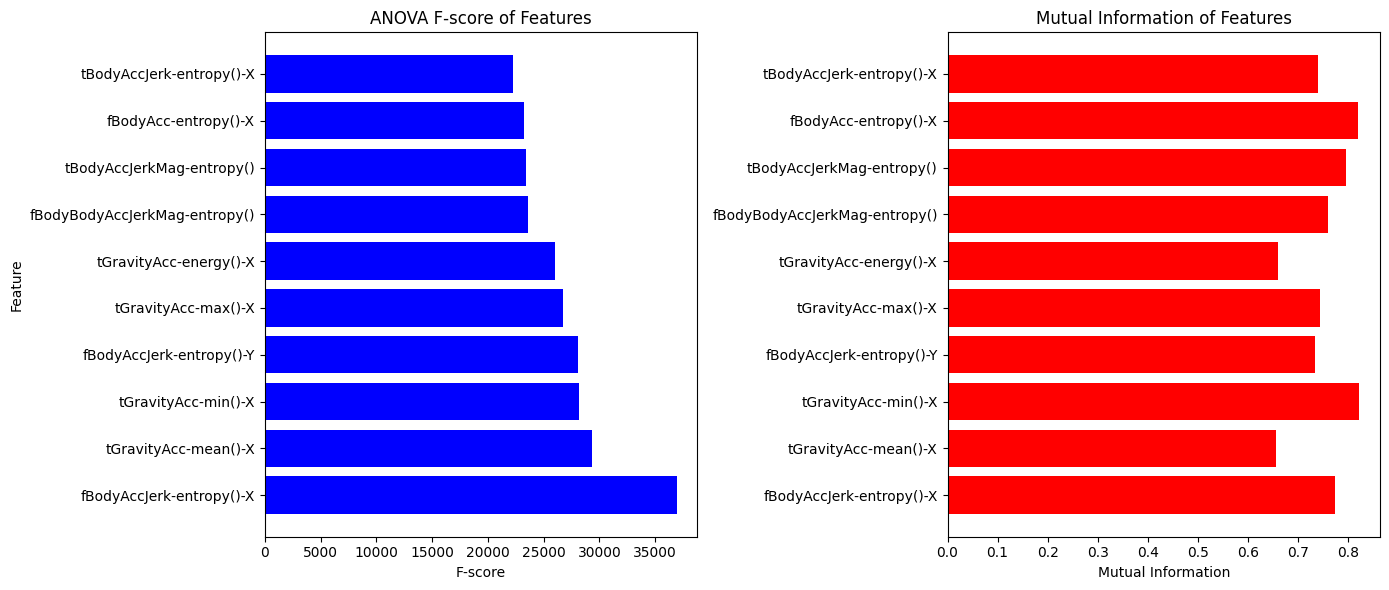

In [23]:
# Set up the plot with two subplots for F-score and Mutual Information
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot ANOVA F-score on the first subplot
ax1.barh(df['feature'], df['anova_score'], color='b')
ax1.set_xlabel('F-score')
ax1.set_ylabel('Feature')
ax1.set_title('ANOVA F-score of Features')

# Plot Mutual Information on the second subplot
ax2.barh(df['feature'], df['mi_score'], color='r')
ax2.set_xlabel('Mutual Information')
ax2.set_title('Mutual Information of Features')

# Adjust layout
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'ace_tools'

In [32]:
!pip install ace-tools

Looking in indexes: https://mirrors.sustech.edu.cn/pypi/simple/


In [34]:
# Creating a table to display the top 10 features with both ANOVA F-score and Mutual Information scores
top_10_features_table = df[['feature', 'anova_score', 'mi_score']].sort_values(by=['anova_score', 'mi_score'], ascending=False)

import ace_tools as tools; tools.display_dataframe_to_user(name="Top 10 Features Comparison", dataframe=top_10_features_table)


ModuleNotFoundError: No module named 'ace_tools'

In [35]:
import pandas as pd

# Display the top 10 features table
top_10_features_table = df[['feature', 'anova_score', 'mi_score']].sort_values(by=['anova_score', 'mi_score'], ascending=False)

# Display the table to the user
top_10_features_table


,feature,anova_score,mi_score
0,fBodyAccJerk-entropy()-X,36918.103883,0.774437
1,tGravityAcc-mean()-X,29362.642369,0.656894
2,tGravityAcc-min()-X,28175.402833,0.822990
3,fBodyAccJerk-entropy()-Y,28115.915817,0.733558
4,tGravityAcc-max()-X,26686.804095,0.744468
5,tGravityAcc-energy()-X,25981.558817,0.660014
6,fBodyBodyAccJerkMag-entropy(),23619.245704,0.760501
7,tBodyAccJerkMag-entropy(),23437.114915,0.796506
8,fBodyAcc-entropy()-X,23221.614156,0.820657
9,tBodyAccJerk-entropy()-X,22267.085935,0.739422


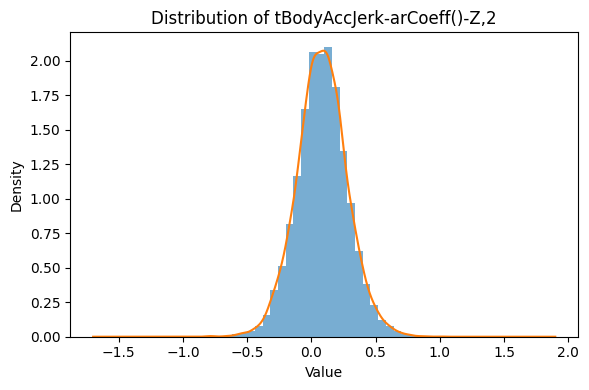

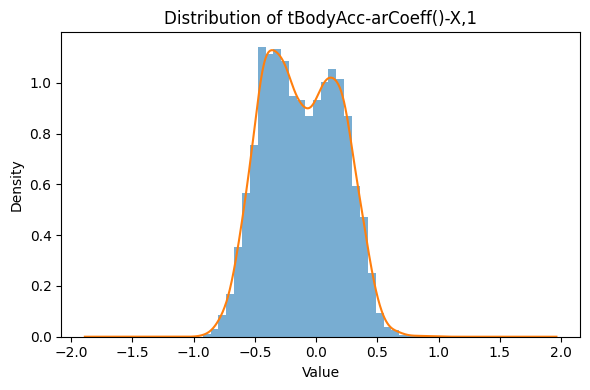

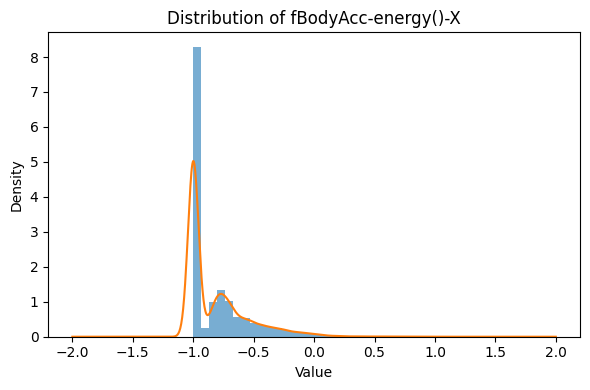

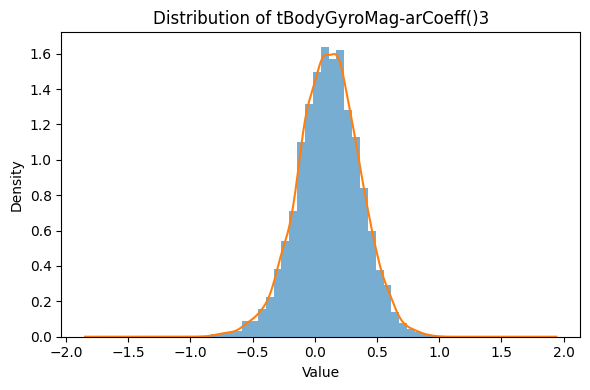

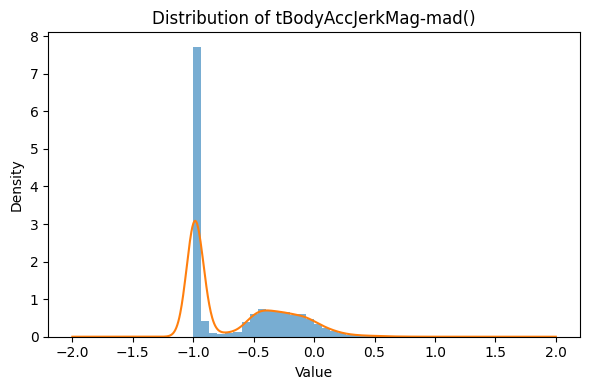

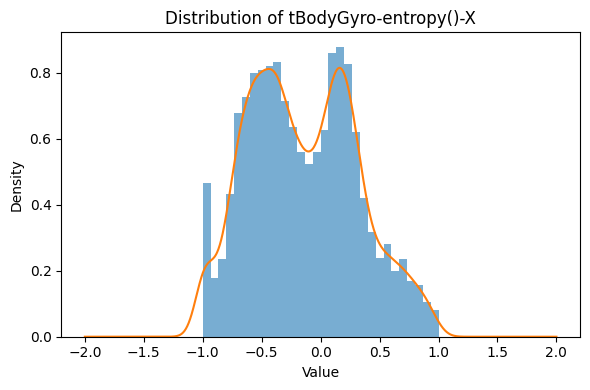

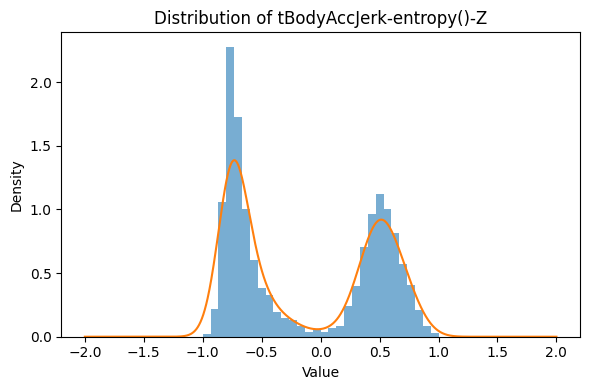

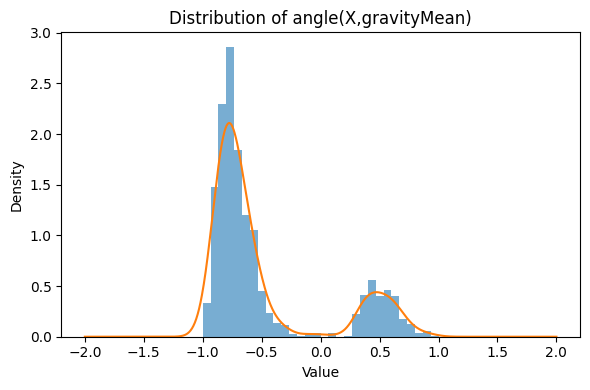

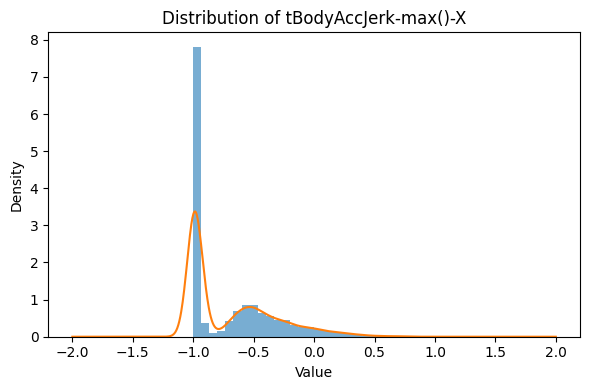

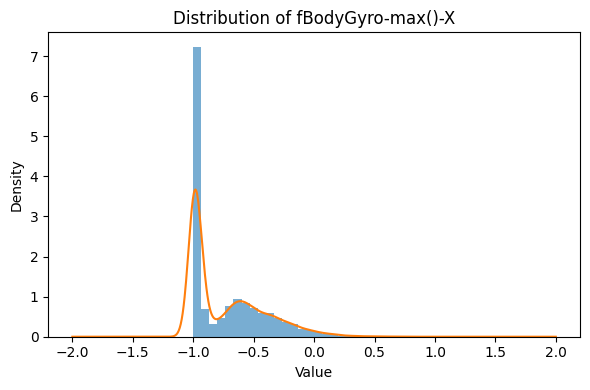

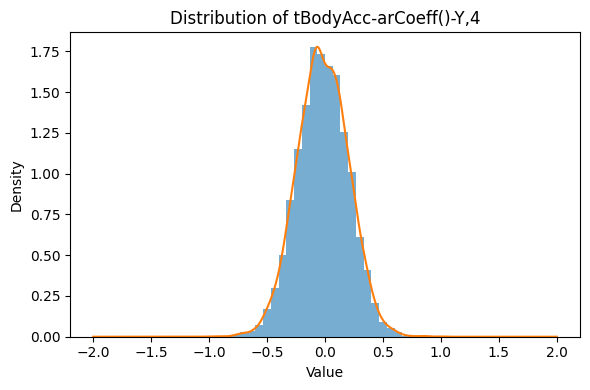

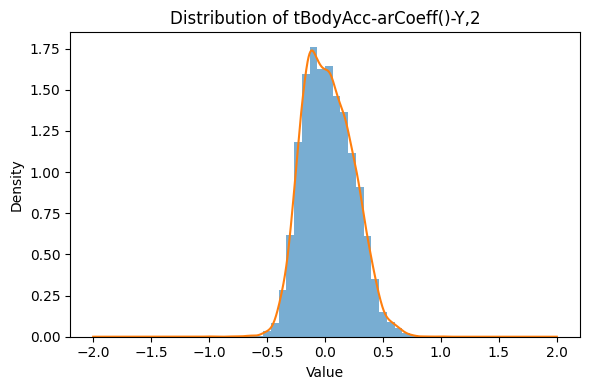

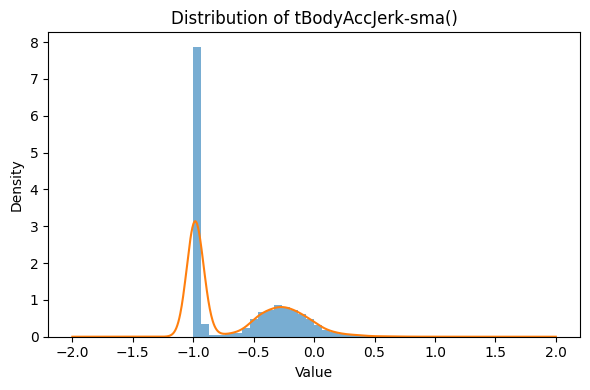

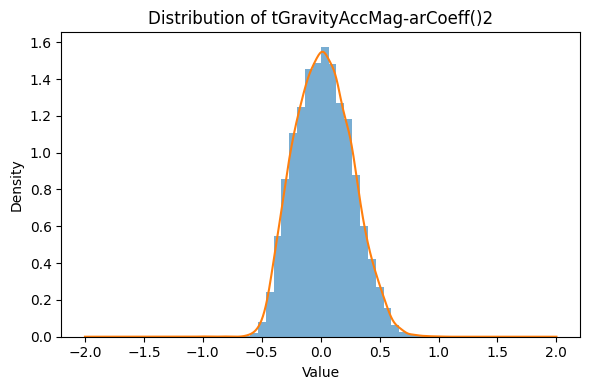

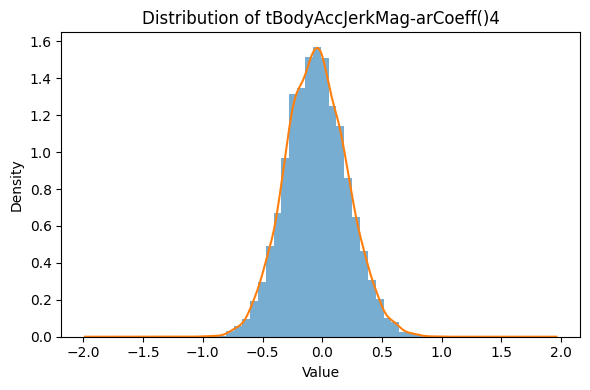

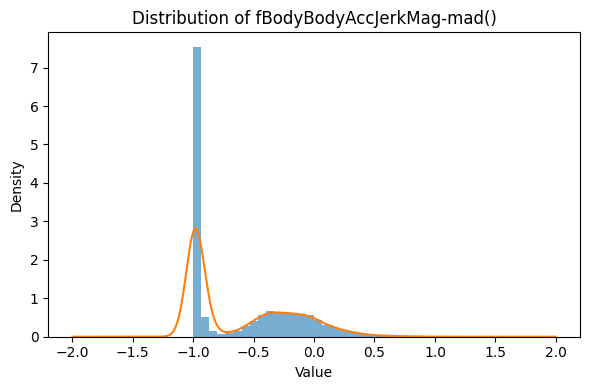

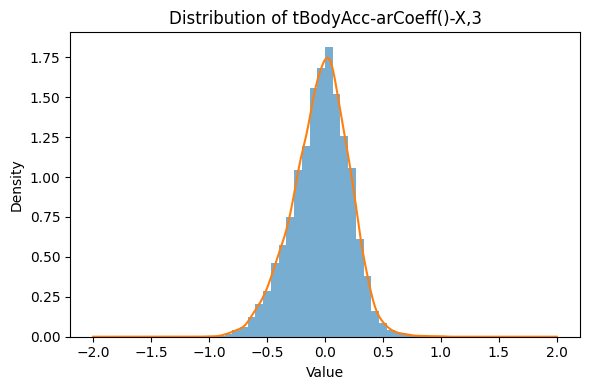

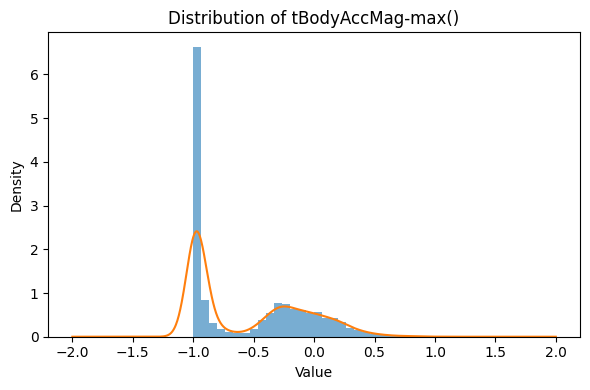

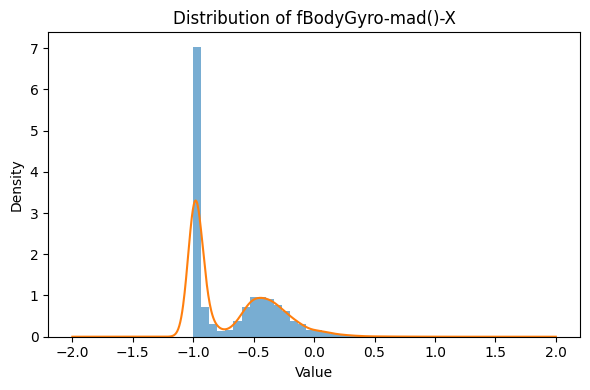

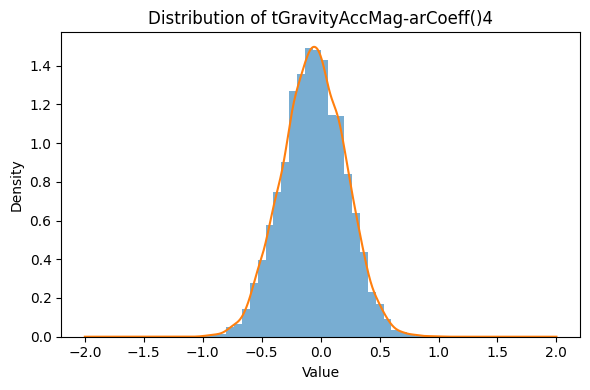

In [37]:
import os
import random
import pandas as pd
import matplotlib.pyplot as plt

# —— 配置路径 —— 
base_dir = './data/UCI_HAR_Dataset/'   # 根据实际解压位置调整

# —— 加载特征名称 —— 
feat_path = os.path.join(base_dir, 'features.txt')
feat = pd.read_csv(feat_path, sep='\s+', header=None, names=['idx','feat'])
feature_names = feat['feat'].tolist()

# —— 加载训练数据（不指定 names，后面再赋） —— 
X_train = pd.read_csv(
    os.path.join(base_dir, 'train', 'X_train.txt'),
    sep='\s+', header=None
)
X_train.columns = feature_names

# —— 随机选取 20 个特征 —— 
random.seed(42)
sample_feats = random.sample(feature_names, 20)

# —— 绘制直方图 + KDE —— 
for fname in sample_feats:
    series = X_train[fname]
    
    plt.figure(figsize=(6,4))
    # 直方图（归一化为密度）
    plt.hist(series, bins=30, density=True, alpha=0.6)
    # KDE 曲线
    series.plot(kind='kde')
    
    plt.title(f'Distribution of {fname}')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()


In [38]:
!pip install umap-learn

Looking in indexes: https://mirrors.sustech.edu.cn/pypi/simple/


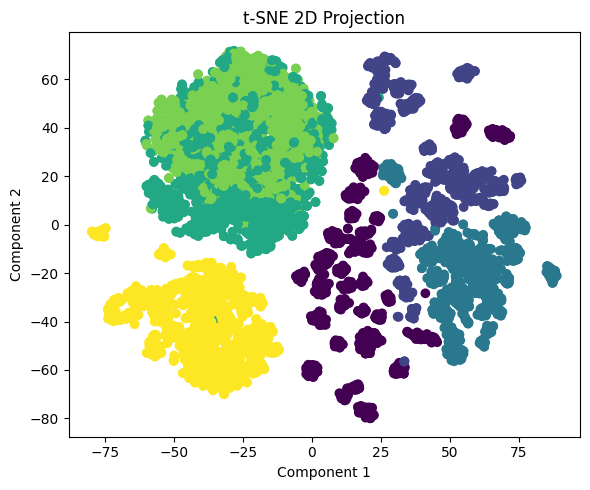

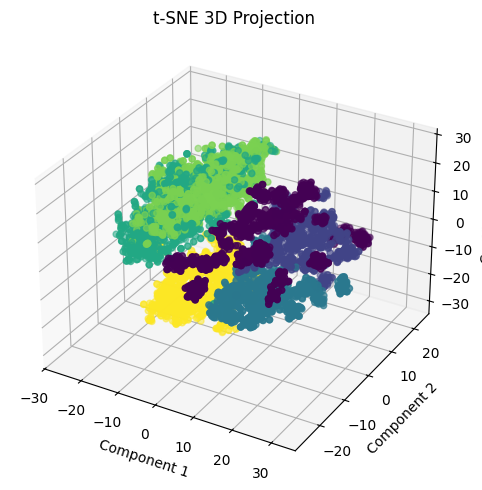

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


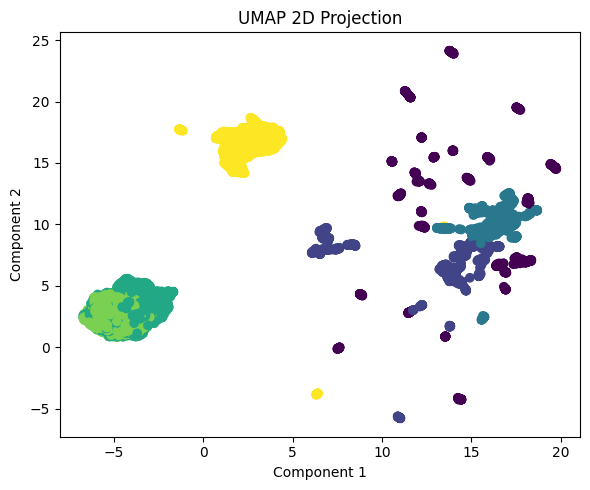

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


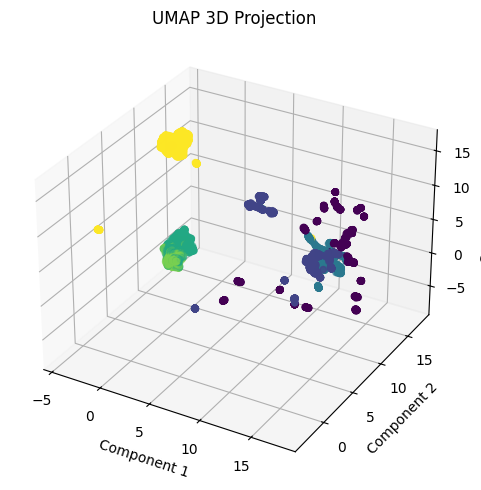

In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# —— 一、加载数据 —— 
base_dir = './data/UCI_HAR_Dataset/'  # 根据实际解压路径调整
feat = pd.read_csv(os.path.join(base_dir, 'features.txt'),
                   sep='\s+', header=None, names=['idx','feat'])
feature_names = feat['feat'].tolist()

X = pd.read_csv(os.path.join(base_dir, 'train', 'X_train.txt'),
                sep='\s+', header=None)
X.columns = feature_names
y = pd.read_csv(os.path.join(base_dir, 'train', 'y_train.txt'),
                sep='\s+', header=None, names=['activity'])['activity']

# —— 二、随机抽样加速——
np.random.seed(42)
sample_idx = np.random.choice(X.shape[0], size=2000, replace=False)
X_sample = X
y_sample = y

# —— 三、t‑SNE 2D —— 
tsne2 = TSNE(n_components=2, random_state=42)
X_tsne2 = tsne2.fit_transform(X_sample)
plt.figure(figsize=(6,5))
plt.scatter(X_tsne2[:,0], X_tsne2[:,1], c=y_sample)
plt.title('t‑SNE 2D Projection')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.tight_layout()
plt.show()

# —— 四、t‑SNE 3D —— 
tsne3 = TSNE(n_components=3, random_state=42)
X_tsne3 = tsne3.fit_transform(X_sample)
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tsne3[:,0], X_tsne3[:,1], X_tsne3[:,2], c=y_sample)
ax.set_title('t‑SNE 3D Projection')
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
plt.tight_layout()
plt.show()

# —— 五、UMAP 2D & 3D —— 
# 如果还没安装，请先运行：pip install umap-learn
try:
    import umap

    # UMAP 2D
    reducer2 = umap.UMAP(n_components=2, random_state=42)
    X_umap2 = reducer2.fit_transform(X_sample)
    plt.figure(figsize=(6,5))
    plt.scatter(X_umap2[:,0], X_umap2[:,1], c=y_sample)
    plt.title('UMAP 2D Projection')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.tight_layout()
    plt.show()

    # UMAP 3D
    reducer3 = umap.UMAP(n_components=3, random_state=42)
    X_umap3 = reducer3.fit_transform(X_sample)
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_umap3[:,0], X_umap3[:,1], X_umap3[:,2], c=y_sample)
    ax.set_title('UMAP 3D Projection')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.tight_layout()
    plt.show()

except ImportError:
    print("未检测到 umap 库，请先运行：pip install umap-learn")
